# Solving an Oscillating Lid-Driven Cavity Flow with Scalar Mixing

_This demo is part of Spitfire, with [licensing and copyright info here.](https://github.com/sandialabs/Spitfire/blob/master/license.md)_


_Highlights_

- solving the two-dimensional incompressible Navier-Stokes equations with a vorticity-streamfunction method
- solving a scalar transport equation with slope limiters
- using Spitfire `odesolve` to solve this problem with the Forward Euler method and a fifth-order method using adaptive time-stepping


## Introduction

The [Navier-Stokes equations](https://en.wikipedia.org/wiki/Navier–Stokes_equations) are an incredibly important system of partial differential equations (PDEs) that describe the motion of a variety of fluids, the flickering candle flames to and air flow over planes and missiles at high speeds. Computational fluid dynamics (CFD) is the use of numerical methods and computers to build models of fluid flow for science and engineering. A common assumption used to simplify the equations for many flows is that the fluid is [incompressible](https://en.wikipedia.org/wiki/Incompressible_flow).

Time-dependent incompressible flows in two dimensions can be solved with the vorticity-streamfunction formulation. In this notebook we use this formulation to solve a two-dimensional lid-driven cavity flow. The lid-driven cavity is a canonical flow for CFD solvers and it is often used for code validation. The setup is quite simple - an incompressible fluid is contained in a box and the upper wall of the box is moved horizontally at a constant velocity. Depending on the type of fluid, this produces a large central vortex and a cascade of turbulent motions. The governing equations for the interior of the cavity flow in dimensionless form are written below, wherein $\omega$ and $\psi$ are the vorticity and streamfunction fields, $(v_x,v_y)$ is the fluid velocity vector, and $\mathrm{Re}$ is the [Reynolds number](https://en.wikipedia.org/wiki/Reynolds_number). The velocity components are obtained from the streamfunction with $v_x = \partial\psi/\partial y$ and $v_y=-\partial\psi/\partial x$.

$$
\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right)\psi = -\omega,
$$

$$
\frac{\partial\omega}{\partial t} = -v_x \frac{\partial\omega}{\partial x} - v_y \frac{\partial\omega}{\partial y} + \frac{1}{\mathrm{Re}}\left(\frac{\partial^2\omega}{\partial x^2} + \frac{\partial^2\omega}{\partial y^2}\right).
$$

In addition to solving the equations above for $\psi$ and $\omega$, we include a scalar transport equation for a transported quantity $Z$ represenative of a pollutant in the air, food coloring in water, or milk in coffee. We represent its specific amount by the symbol $Z$, and its transport equation, which includes the [Schmidt number](https://en.wikipedia.org/wiki/Schmidt_number) to incorporate diffusion of the scalar relative to fluid momentum.

$$
\frac{\partial Z}{\partial t} = -v_x \frac{\partial Z}{\partial x} - v_y \frac{\partial Z}{\partial y} + \frac{1}{\mathrm{Re}\mathrm{Sc}}\left(\frac{\partial^2 Z}{\partial x^2} + \frac{\partial^2 Z}{\partial y^2}\right).
$$

The initial conditions for the PDEs above are $\psi=0$ and $\omega=0$ while $Z=1$ is set in two vertical stripes and $Z=0$ elsewhere. Boundary conditions are the standard set for a cavity flow with one exception - rather than specifying a constant lid velocity, $v_{\mathrm{lid}}$, we oscillate in time to get more interesting dynamics in the scalar field. The specific form is

$$
v_{\mathrm{lid}}(t) = \cos\left(\frac{2 \pi}{\tau}t\right),
$$

where $\tau$ is the oscillation period. With this form of $v_{\mathrm{lid}}(t)$, the lid will start moving rapidly to the right before switching direction and moving rapidly to the left, reaching its peak leftward velocity at $t=\tau/2$ and returning to its peak rightward velocity again at $t\tau$.


## Spatial Discretization

Spitfire provides `odesolve` to solve ordinary differential equations, so the first step in solving the PDEs above is spatial discretization, namely splitting the spatial domain into cells, elements, or nodes and approximating some form of the PDEs in the discretized space. We employ a standard nodal [finite difference](https://en.wikipedia.org/wiki/Finite_difference_coefficient) scheme here, and slope limiters are used for the advective terms.
Slope limiters enable us to blend dissipative upwind schemes where velocities or scalar gradients are large, and more accurate but oscillatory centered schemes in the rest of the domain.
Below we'll run with a purely centered scheme that will generate over- and under-shoots of the scalar field, a purely upwind scheme that smooths everything away as if viscosity were higher, and with two different limiters that both perform significantly better than the upwind or central schemes.


## Solving with Spitfire

After discretizing the PDEs in space onto a grid with $n=n_x\times n_y$ nodes, we are left with a large number of _ordinary_ differential equations (ODEs). These ODEs can be solved with Spitfire's `odesolve` method. We'll use `odesolve` with two explicit methods, namely the Forward Euler method and a well-known Runge-Kutta method (the [Cash-Karp method](https://en.wikipedia.org/wiki/Cash–Karp_method)) that enables adaptive time-stepping through error control. Several of the prior Spitfire demonstrations discuss these method and adaptive time-stepping in more detail.

An important feature of the PDEs above is that the streamfunction equation is not written with an explicit time derivative, which results from the assumption that the fluid is incompressible. The streamfunction must be computed implicitly from the vorticity field. The PDE above is a standard Poisson problem, and after spatial discretization it becomes a linear system of algebraic equations instead of differential equations. Practically, this means that we will need to solve this linear system to update $\psi$ at each time step or possibly at each stage of the Runge-Kutta method. From $\psi$ we can then update the velocity components with the formulas above and compute the right-hand sides of the ODEs for $\omega$ and $Z$. This step is built into a method of the `LidDrivenCavity` class discussed further below, and can be plugged into `odesolve` with the `pre_step_callback` argument to recompute $\psi$ at the start of each time step.

In [1]:
import numpy as np
from time import perf_counter
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import splu

## `LidDrivenCavity` a "model" class for `odesolve`

A common theme in solving complex problems with `odesolve` is defining a Python class to simplify problem setup and various ingredients required to solve the system such as ODE right-hand side or Jacobian evaluations. The `LidDrivenCavity` class below packages up all the details of setting up a cavity flow, evaluating the right-hand side for the transport equations, solving linear systems for the streamfunction, slope limiters, and even extracting two-dimensional numpy arrays to simplify plotting after the ODEs have been solved. Writing classes like this to package your data makes it far easier to run studies as we will below, solving with eight different combinations of finite differencing schemes (upwind, central, two limiters) and time-stepping schemes (Forward Euler, Cash-Karp RK). The inline comments below should help understand all the variuos pieces of this particular class.

In [2]:
class LidDrivenCavity:
    def __init__(self, 
                 n,                            # number of grid points in each direction (a grid of n^2 pts results)
                 Re,                           # the Reynolds number
                 Sc,                           # the Schmidt number
                 scheme,                       # the differencing scheme to use: 'central', 'upwind', 'minmod', 'van Albada'
                 stage_velocity_update=False,  # whether or not to solve the expensive streamfunction system every stage (True) or once per step (False)
                 stage_limiter=False,          # whether or not to recalculate the expensive limiter every stage (True) or once per step (False)
                 tau=10.):                     # period of lid velocity oscillation (see tau above)
        print('Initializing lid driven cavity...')
        self._n = n
        self._n2 = n * n
        x = np.linspace(0., 1, self._n)
        y = np.linspace(0., 1, self._n)
        xg, yg = np.meshgrid(x, y)
        self._xgrid = np.copy(xg)
        self._ygrid = np.copy(yg)
        
        dx = x[1] - x[0]
        dy = y[1] - y[0]
        self._invdx = 1. / dx
        self._invdy = 1. / dy
        self._invdx2 = self._invdx * self._invdx
        self._invdy2 = self._invdy * self._invdy
        
        self._Re = Re
        self._Sc = Sc
        self._invRe = 1. / Re
        self._invSc = 1. / Sc
        
        self._dt = np.min([dx * dx * Re, 1. / Re])  # characteristic time scale from linear stability analysis
        
        Ae = self._invdx2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        Aw = self._invdx2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        As = self._invdy2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        An = self._invdy2 * np.ones_like(self._xgrid)[1:-1,1:-1]
        Ap = -(Aw + Ae + An + As)
        Ae[:,-1] = 0.
        Aw[:,0] = 0.
        An[-1,:] = 0.
        As[0,:] = 0.
        nn = (self._n - 2) * (self._n - 2)
        d0 = Ap.reshape(nn)
        de = Ae.reshape(nn)[:-1]
        dw = Aw.reshape(nn)[1:]
        ds = As.reshape(nn)[(self._n - 2):]
        dn = An.reshape(nn)[:-(self._n - 2)]
        psi_lhs_op = diags([d0, de, dw, dn, ds], 
                           [0, 1, -1, (self._n - 2), -(self._n - 2)], 
                           format='csc')
        self._psi_inv_op = splu(psi_lhs_op)  # factorizing the linear system for the streamfunction once
        self._psi_wall = 0.
        
        self._psi = np.zeros_like(self._xgrid)
        self._vx = np.zeros_like(self._xgrid[1:-1, 1:-1])
        self._vy = np.zeros_like(self._xgrid[1:-1, 1:-1])
        self._w0 = np.zeros_like(self._xgrid)
        self._z0 = np.zeros_like(self._xgrid)
        
        self._wphix = np.zeros_like(self._vx)
        self._wphiy = np.zeros_like(self._vy)
        self._zphix = np.zeros_like(self._vx)
        self._zphiy = np.zeros_like(self._vy)
        
        self._scheme = scheme
        self._limiter = {'upwind': 'upwind',
                         'central': 'central',
                         'minmod': self._minmod,
                         'van Albada': self._van_Albada}[scheme]
        self._using_limiter = self._limiter not in ['upwind', 'central']
        self._stage_limiter = stage_limiter
        
        self._stage_velocity_update = stage_velocity_update
        
        self._vx_wall = lambda t : np.cos(2. * np.pi / tau * t)
        
        print('Done initializing. Don\'t forget to set z0 to the desired initial scalar profile.')
    
    @property
    def xgrid(self):
        return self._xgrid
    
    @property
    def ygrid(self):
        return self._ygrid
    
    @property
    def z0(self):
        return self._z0
    
    @z0.setter
    def z0(self, z0vals): # this "setter" allows one to say cavity.z0 = ... to initialize the scalar field
        self._z0 = np.copy(z0vals)
        self._z0[0,:] = self._z0[1,:]
        self._z0[-1,:] = self._z0[-2,:]
        self._z0[:,0] = self._z0[:,1]
        self._z0[:,-1] = self._z0[:,-2]
    
    @property
    def initial_state(self):
        return np.hstack((self._w0.ravel(), self._z0.ravel()))  # building the 2D np.ndarrays into a flat state for odesolve
    
    @property
    def dt(self):
        return self._dt
    
    @property
    def scheme(self):
        return self._scheme
    
    def _apply_w_bcs(self, t, w, psi):  # applying boundary conditions for the vorticity
        w[:,0] = 2.0 * (self._psi_wall - self._psi[:,1]) * self._invdx2
        w[:,-1] = 2.0 * (self._psi_wall - self._psi[:,-2]) * self._invdx2
        w[0,:] = 2.0 * (self._psi_wall - self._psi[1,:]) * self._invdy2
        w[-1,:] = 2.0 * (self._psi_wall - self._psi[-2,:]) * self._invdy2 - 2.0 * self._invdy * self._vx_wall(t)
        
    def _apply_scalar_bcs(self, z):  # applying boundary conditions for any other transported quantity
        z[0,:] = z[1,:]
        z[-1,:] = z[-2,:]
        z[:,0] = z[:,1]
        z[:,-1] = z[:,-2]
        
    def _minmod(self, r):
        return np.maximum(0., np.minimum(1., r))
    
    def _van_Albada(self, r):
        return 2. * r / (r * r + 1.)
    
    def _update_velocities(self, w):  # solve the streamfunction linear system and recompute the velocities
        self._psi[1:-1, 1:-1] = self._psi_inv_op.solve(-w[1:-1, 1:-1].ravel()).reshape([self._n - 2, self._n - 2])
        self._vx = 0.5 * (self._psi[2:,1:-1] - self._psi[:-2,1:-1]) * self._invdy
        self._vy = -0.5 * (self._psi[1:-1,2:] - self._psi[1:-1,:-2]) * self._invdx
    
    def _update_limiter(self, w, z):
        if self._using_limiter:
            self._wphix = self._limiter((w[1:-1,1:-1] - w[1:-1,:-2]) / ((w[1:-1,2:] - w[1:-1,1:-1]) + 1.e-6))
            self._wphiy = self._limiter((w[1:-1,1:-1] - w[:-2,1:-1]) / ((w[2:,1:-1] - w[1:-1,1:-1]) + 1.e-6))
            self._zphix = self._limiter((z[1:-1,1:-1] - z[1:-1,:-2]) / ((z[1:-1,2:] - z[1:-1,1:-1]) + 1.e-6))
            self._zphiy = self._limiter((z[1:-1,1:-1] - z[:-2,1:-1]) / ((z[2:,1:-1] - z[1:-1,1:-1]) + 1.e-6))
    
    def pre_step(self, t, state, *args, **kwargs):  # feed to odesolve's pre_step_callback argument to run this function at the start of a time step
        if not self._stage_velocity_update:
            w = np.reshape(state[:self._n2], (self._n, self._n))
            self._update_velocities(w)
        
        if not self._stage_limiter:
            w = np.reshape(state[:self._n2], (self._n, self._n))
            z = np.reshape(state[:self._n2], (self._n, self._n))
            self._update_limiter(w, z)
    
    def _compute_transport_rhs(self, vx, vy, phix, phiy, q, coeff):
        qe = q[1:-1,2:]
        qw = q[1:-1,:-2]
        qs = q[:-2,1:-1]
        qn = q[2:,1:-1]
        qp = q[1:-1,1:-1]
        if self._limiter == 'central':
            qx = 0.5 * self._invdx * (qe - qw)
            qy = 0.5 * self._invdy * (qn - qs)
        elif self._limiter == 'upwind':
            qx = self._invdx * np.where(vx < 0., qe - qp, qp - qw)
            qy = self._invdy * np.where(vy < 0., qn - qp, qp - qs)
        else:
            qxc = 0.5 * self._invdx * (qe - qw)
            qyc = 0.5 * self._invdy * (qn - qs)
            qxu = self._invdx * np.where(vx < 0., qe - qp, qp - qw)
            qyu = self._invdy * np.where(vy < 0., qn - qp, qp - qs)
            qx = qxu - phix * (qxu - qxc)
            qy = qyu - phiy * (qyu - qyc)
        
        qxx = (qe - 2. * qp + qw) * self._invdx2
        qyy = (qn - 2. * qp + qs) * self._invdy2
        
        rhs = np.zeros_like(self._xgrid)
        rhs[1:-1,1:-1] = - vx * qx - vy * qy + coeff * (qxx + qyy)
        return rhs.ravel()
    
    def post_step(self, t, state, *args, **kwargs):  # feed to odesolve's post_step_callback argument to run this check at the end of each time step
        if np.any(np.isnan(state)):
            raise ValueError('NaN/Inf detected in solution!')
            
    def rhs(self, t, state):  # finally, the right-hand side of the spatially discretized system of ODEs
        w = np.reshape(state[:self._n2], (self._n, self._n))
        z = np.reshape(state[self._n2:], (self._n, self._n))
        
        if self._stage_velocity_update:
            self._update_velocities(w)
        
        if self._stage_limiter:
            self._update_limiter(w, z)
        
        self._apply_w_bcs(t, w, self._psi)
        self._apply_scalar_bcs(z)
        
        rhs = np.zeros_like(state)
        rhs[:self._n2] = self._compute_transport_rhs(self._vx, self._vy, self._wphix, self._wphiy, w, self._invRe)
        rhs[self._n2:] = self._compute_transport_rhs(self._vx, self._vy, self._zphix, self._zphiy, z, self._invRe * self._invSc)
        
        return rhs
    
    def extract_wz(self, state):  # getting 2D np.ndarrays out of a flattened state vector or time history of the states
        if len(state.shape) > 1:
            w = state[:, :self._n2].reshape((state.shape[0], self._n, self._n))
            z = state[:, self._n2:].reshape((state.shape[0], self._n, self._n))
        else:
            w = state[:self._n2].reshape((self._n, self._n))
            z = state[self._n2:].reshape((self._n, self._n))
        return w, z

Now we make four different instances of the `LidDrivenCavity` class, each parameterized the same way but for the spatial discretization scheme. Following this we use magic NumPy indexing to set up two vertical stripes of the initial scalar field.

Note that we specify only 72x72 grids for the example, and also a Reynolds number of 1,000 and Schmidt number of 100. This is to make the example run pretty quickly. To obtain much more interesting results, you are encouraged to run this with $128^2$, $256^2$ and $512^2$ grids and Re=40,000 with Sc=1,000. These will take a bit longer to run - with the adaptive RK method (substantially faster than Forward Euler) on $512^2$ grids expect maybe an hour or so per case, depending on how many oscillation periods you want to simulate.

In [3]:
n = 72
Re = 1000.
Sc = 100.

flow_vanAlbada = LidDrivenCavity(n, Re, Sc, scheme='van Albada', stage_limiter=False, stage_velocity_update=False)
flow_minmod    = LidDrivenCavity(n, Re, Sc, scheme='minmod', stage_limiter=False, stage_velocity_update=False)
flow_upwind    = LidDrivenCavity(n, Re, Sc, scheme='upwind', stage_limiter=False, stage_velocity_update=False)
flow_central   = LidDrivenCavity(n, Re, Sc, scheme='central', stage_limiter=False, stage_velocity_update=False)

xgrid = flow_minmod.xgrid
ygrid = flow_minmod.ygrid

indices = np.logical_or(np.logical_and(xgrid > 0.2, xgrid < 0.4),
                        np.logical_and(xgrid > 0.6, xgrid < 0.8))

flow_vanAlbada.z0[indices] = 1.0
flow_minmod.z0[indices] = 1.0
flow_upwind.z0[indices] = 1.0
flow_central.z0[indices] = 1.0

Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.
Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.
Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.
Initializing lid driven cavity...
Done initializing. Don't forget to set z0 to the desired initial scalar profile.


To simplify our parameter study, we write the `solve_case` method. This just removes some boilerplate code shared by all of the cases. Note that in the call to `odesolve`, we're passing the `rhs`, `pre_step`, and `post_step` methods on the `LidDrivenCavity` instance.

In [4]:
from spitfire import odesolve, PIController, CashKarpS6P5Q4, ForwardEulerS1P1
from time import perf_counter

tf = 30.  # three oscillation periods
output_times = np.linspace(0, tf, 101)

def solve_case(sol_dict, flow, method_name, log_rate=500, verbose=False):
    if method_name == 'RK5':
        step_size = PIController(first_step=flow.dt, 
                                 target_error=1e-2, 
                                 max_step=1.e3 * flow.dt)
        method = CashKarpS6P5Q4()
    elif method_name == 'FE':
        step_size = flow.dt
        method = ForwardEulerS1P1()
    
    print(f'Running {method_name}, {flow.scheme} ...', end='')
    tic = perf_counter()
    statesRK = odesolve(flow.rhs, 
                        flow.initial_state,
                        output_times, 
                        step_size=step_size, 
                        method=method, 
                        verbose=verbose, 
                        log_rate=log_rate,
                        pre_step_callback=flow.pre_step,
                        post_step_callback=flow.post_step)

    sol_dict[(method_name, flow.scheme)] = flow.extract_wz(statesRK)[1]
    
    print(f' done in {perf_counter() - tic:.1f} s')
    return sol_dict

In [5]:
sol_dict = dict()

sol_dict = solve_case(sol_dict, flow_vanAlbada, 'RK5')
sol_dict = solve_case(sol_dict, flow_upwind   , 'RK5')
sol_dict = solve_case(sol_dict, flow_central  , 'RK5')
sol_dict = solve_case(sol_dict, flow_minmod   , 'RK5')

sol_dict = solve_case(sol_dict, flow_vanAlbada, 'FE')
sol_dict = solve_case(sol_dict, flow_upwind   , 'FE')
sol_dict = solve_case(sol_dict, flow_minmod   , 'FE')
sol_dict = solve_case(sol_dict, flow_central  , 'FE')

Running RK5, van Albada ... done in 6.6 s
Running RK5, upwind ... done in 5.1 s
Running RK5, central ... done in 3.7 s
Running RK5, minmod ... done in 6.8 s
Running FE, van Albada ... done in 50.8 s
Running FE, upwind ... done in 42.0 s
Running FE, minmod ... done in 50.8 s
Running FE, central ... done in 39.0 s


The plots below show the scalar field at the final time after three oscillation periods, for the eight variations of time-stepping scheme and spatial differencing scheme. The color scheme is cut off at 1% above the initial maximum value of the scalar density (1). This is meant to show the presence of nontrivial oscillations, for instance those that dominate the solution with the central scheme. This is an expected result for the central scheme, along with the extremely smoothed result of the upwind scheme. In contrast, the limiters do quite well in reducing oscillations, although the significant difference between minmod and van Albada is interesting. 

While the adaptive RK scheme and Forward Euler method seem to have given fairly similar solutions for the upwind and limiter schemes, adaptive time-stepping is computing that solution around six to eight times faster for this problem. The speedup of the adaptive scheme is much more significant (around twenty times) on larger grids. Also, note that while the central scheme gives a bad answer for both the Forward Euler and RK schemes, it certainly seems like the adaptive RK method is doing a better job of minimizing the oscillations.

In the following cells we define a function to simplify the process of making animations and movies with matplotlib. The `save_to_file` argument in the `movie` function allows you to save the animation to a file if you'd like.

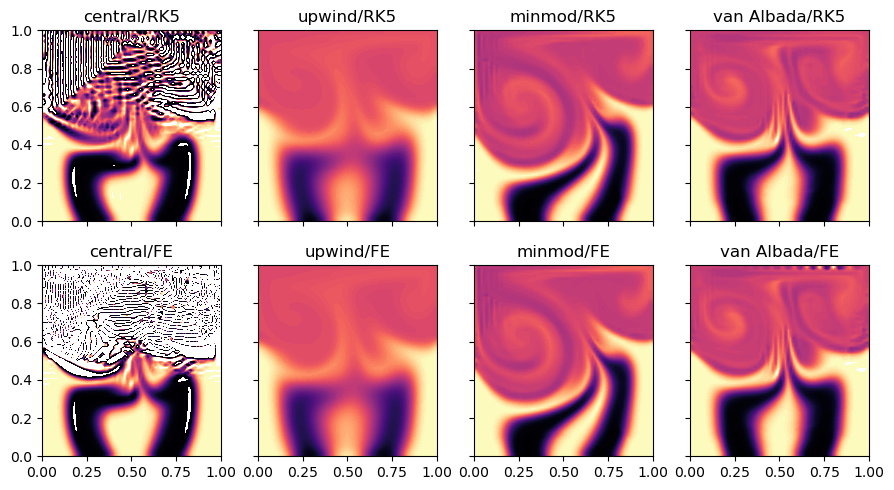

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

time_idx = -1

fig, axarray = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(9, 5))

for ids, scheme in enumerate(['central', 'upwind', 'minmod', 'van Albada']):
    for idm, method in enumerate(['RK5', 'FE']):
        c = axarray[idm, ids].contourf(flow_minmod.xgrid, 
                                       flow_minmod.ygrid, 
                                       sol_dict[(method, scheme)][time_idx, :, :], 
                                       levels=np.linspace(0, 1.01, 80), 
                                       cmap='magma_r', 
                                       norm=Normalize(0, 1.0))
        axarray[idm, ids].set_title(f'{scheme}/{method}')
plt.tight_layout()
plt.show()

## Conclusions

This notebook has shown how `odesolve` can be used to drive adaptive time-stepping methods in solving a time-dependent  two-dimensional lid-driven cavity flow. This is the first Spitfire demonstration where the system of ODEs being solved is complicated enough to motivate a Python class to package the setup, right-hand side, and more methods used by `odesolve`.